In [1]:
# Code to plot SSTs/SST anomalies for the ENSO region
# Author: Nathan Erickson
# Date: 1/11/2022
# Coded with Python 3.8.10

In [2]:
import os
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pandas as pd
import xarray as xr
import numpy as np
from datetime import datetime

ERROR 1: PROJ: proj_create_from_database: Open of /opt/miniconda3/envs/prod/share/proj failed


In [3]:
home_dir = '/chinook2/nathane1/Thesis/'
os.chdir(home_dir)
obs_ssts = xr.open_dataset('sst.mnmean.nc')

In [4]:
obs_ssts.sst

<xarray.DataArray 'sst' (time: 2012, lat: 89, lon: 180)>
[32232240 values with dtype=float32]
Coordinates:
  * lat      (lat) float32 88.0 86.0 84.0 82.0 80.0 ... -82.0 -84.0 -86.0 -88.0
  * lon      (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
  * time     (time) datetime64[ns] 1854-01-01 1854-02-01 ... 2021-08-01
Attributes:
    long_name:     Monthly Means of Sea Surface Temperature
    units:         degC
    var_desc:      Sea Surface Temperature
    level_desc:    Surface
    statistic:     Mean
    dataset:       NOAA Extended Reconstructed SST V5
    parent_stat:   Individual Values
    actual_range:  [-1.8     42.32636]
    valid_range:   [-1.8 45. ]

In [5]:
djf_ssts = obs_ssts.sst.loc[[(np.datetime_as_string(obs_ssts.sst['time'].values)[time][5:7]  == '01') or
              (np.datetime_as_string(obs_ssts.sst['time'].values)[time][5:7]  == '02') or
              (np.datetime_as_string(obs_ssts.sst['time'].values)[time][5:7]  == '12') for time in range(len(obs_ssts.sst['time'].values))]]

In [6]:
rolled_djf_ssts = xr.merge([djf_ssts[::3].rolling(time = 5, center = True).mean(), djf_ssts[1::3].rolling(time = 5, center = True).mean(),
                      djf_ssts[2::3].rolling(time = 5, center = True).mean()]).sst

In [7]:
djf_sst_anoms = djf_ssts - rolled_djf_ssts
djf_sst_anoms = xr.DataArray.rename(djf_sst_anoms, 'SST Anomalies ($^\circ$C)')

In [8]:
djf_sst_anoms[386:388].groupby("lat").mean("time")

<xarray.DataArray 'SST Anomalies ($^\\circ$C)' (lat: 89, lon: 180)>
array([[4.76837159e-08, 4.76837159e-08, 4.76837159e-08, ...,
        4.76837159e-08, 4.76837159e-08, 4.76837159e-08],
       [4.76837159e-08, 4.76837159e-08, 4.76837159e-08, ...,
        4.76837159e-08, 4.76837159e-08, 4.76837159e-08],
       [4.76837159e-08, 4.76837159e-08, 4.76837159e-08, ...,
        4.76837159e-08, 4.76837159e-08, 4.76837159e-08],
       ...,
       [           nan,            nan,            nan, ...,
                   nan,            nan,            nan],
       [           nan,            nan,            nan, ...,
                   nan,            nan,            nan],
       [           nan,            nan,            nan, ...,
                   nan,            nan,            nan]])
Coordinates:
  * lat      (lat) float32 88.0 86.0 84.0 82.0 80.0 ... -82.0 -84.0 -86.0 -88.0
  * lon      (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0

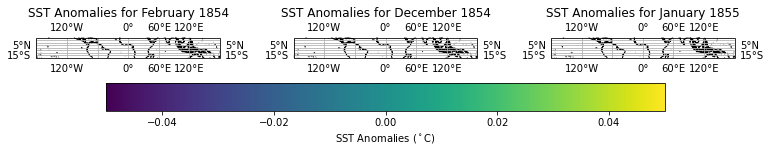

In [15]:
time_step = [1,2,3]
datestrings = [datetime.strftime(pd.to_datetime(str(djf_sst_anoms.time[time].values)), "%B %Y") for time in time_step]

anom_plot = djf_sst_anoms.isel(time=time_step).plot(
    transform=ccrs.PlateCarree(),  # this is important!
    col = "time",
    # usual xarray stuff
    subplot_kws={"projection": ccrs.PlateCarree()},
    cbar_kwargs={"orientation": "horizontal", "shrink": 0.8},
    robust=True,
)

plt.subplots_adjust(bottom = 0.3, wspace = 0.4) # Adjust padding of figures

try:
    for index,ax in enumerate(anom_plot.axes.flat):
        ax.coastlines()
        ax.gridlines(draw_labels=True)
        ax.set_extent([0, 359, 20, -20], crs=ccrs.PlateCarree())
        title_date = datestrings[index]
        ax.set_title(f'SST Anomalies for {title_date}')
except AttributeError:
    anom_plot.coastlines()
    anom_plot.gridlines(draw_labels=True)
    anom_plot.set_extent([-179, -60, 20, -20], crs=ccrs.PlateCarree())
    title_date = 'DJF SST Anomalies'
    anom_plot.set_title(f'SST Anomalies for {title_date}')

In [11]:
anom_plot

In [281]:
img_dir = os.path.join(home_dir,'images')
os.chdir(img_dir)
try:
    sst_anom_fig = anom_plot.get_figure()
    sst_anom_fig.savefig(f'sst_anoms_{title_date.replace(" ","_")}.jpg', bbox_inches = 'tight')
except AttributeError: 
    sst_anom_fig = anom_plot.fig.get_figure()
    sst_anom_fig.savefig(f'sst_anoms_DJF_{str(djf_sst_anoms.time[time_step][0].values)[0:4]}-{str(djf_sst_anoms.time[time_step][1].values)[0:4]}.jpg', 
                         bbox_inches = 'tight')